# Spoken Digit Recognition

In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import warnings
warnings.filterwarnings('ignore')
import random
import matplotlib.pyplot as plt
import wave
import sys
import IPython
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
%load_ext tensorboard
import datetime
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow_addons as tfa
from tqdm import tqdm
import pickle as pkl

In [2]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self,validation_data):
        super().__init__()
        self.x_test = validation_data[0]
        self.y_test = validation_data[1]
        
    def on_epoch_end(self,epoch,logs={}):
        val_predict = (np.asarray(self.model.predict(self.x_test)))
        val_label = np.argmax(val_predict,axis=1)
        val_targ = self.y_test
        val_f1 = f1_score(val_targ,val_label,average='micro')
        
        print("\nEpoch : ", epoch+1 , "val_F1_Score :", val_f1)

In [3]:
class LSTM_Network(tf.keras.Model):
    def __init__(self,lstm_units,input_length):
        super().__init__()
        self.lstm_units= lstm_units
        self.input_length = input_length
        self.lstm = LSTM(self.lstm_units, return_state=True, return_sequences=True)

    def call(self,data):
        outputs = []
        initial_state = None
        for timestep in range(self.input_length):
            lstm_output, state_h, state_c = self.lstm(data[:,timestep:timestep+1],initial_state=initial_state)
            initial_state = [state_h, state_c]
            outputs.append(tf.reduce_mean(lstm_output,-1))
        return tf.squeeze(tf.stack(outputs,axis=1),axis=2)

In [2]:
all_files = os.listdir('recordings')

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

## Exploring the sound dataset

In [5]:
def visualize_sound(filepath):
    spf = wave.open(filepath, "r")

    # Extract Raw Audio from Wav File
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, "Int16")


    # If Stereo
    if spf.getnchannels() == 2:
        print("Just mono files")
        sys.exit(0)

    plt.title(filepath)
    plt.plot(signal)
    plt.show()
    IPython.display.display(IPython.display.Audio(filepath))
    print('-'*100)

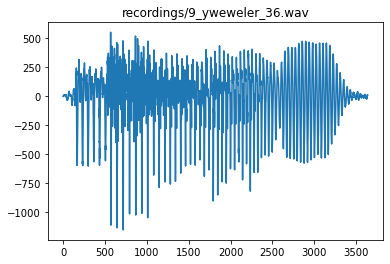

----------------------------------------------------------------------------------------------------


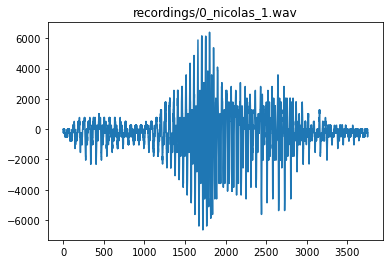

----------------------------------------------------------------------------------------------------


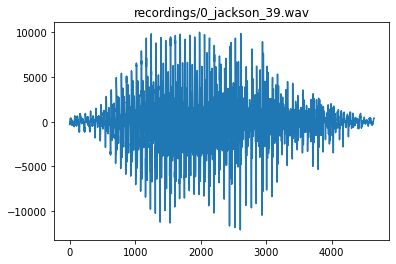

----------------------------------------------------------------------------------------------------


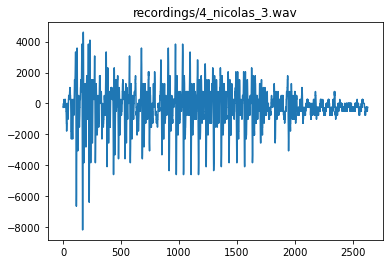

----------------------------------------------------------------------------------------------------


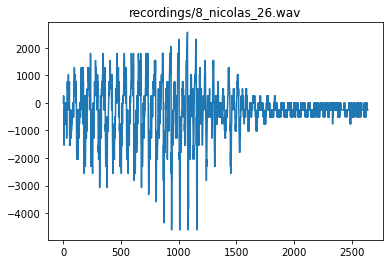

----------------------------------------------------------------------------------------------------


In [6]:
for s in random.sample(all_files,5):
    visualize_sound('recordings/' + s)

In [7]:
df_audio = pd.DataFrame({'path' : all_files , 'label' : [int(p[0]) for p in all_files]})
df_audio.head()

,path,label
0,0_jackson_0.wav,0
1,0_jackson_1.wav,0
2,0_jackson_10.wav,0
3,0_jackson_11.wav,0
4,0_jackson_12.wav,0


In [8]:
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [10]:
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_audio['path'],df_audio['label'], test_size=0.3,
                                                    random_state=45, stratify = df_audio['label'])

In [10]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [14]:
X_train_processed = pd.DataFrame([load_wav('recordings/' +i) for i in X_train] , index = X_train.index, columns = ('raw_data', 'duration'))
X_test_processed = pd.DataFrame([load_wav('recordings/' +i) for i in X_test] , index = X_test.index, columns = ('raw_data', 'duration'))

In [15]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 1394 to 405
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   raw_data  1400 non-null   object 
 1   duration  1400 non-null   float64
dtypes: float64(1), object(1)
memory usage: 32.8+ KB


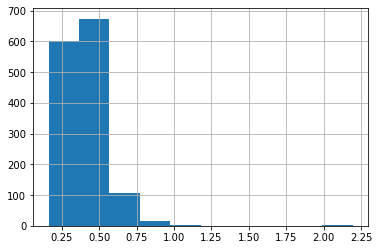

In [16]:
X_train_processed.duration.hist()
plt.show()

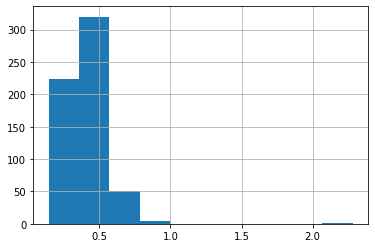

In [17]:
X_test_processed.duration.hist()
plt.show()

In [18]:
for i in range(0,101,10):print(i,' th percentile is ',np.percentile(X_train_processed.duration,i))

0  th percentile is  0.16104308390022676
10  th percentile is  0.25848072562358276
20  th percentile is  0.2974331065759637
30  th percentile is  0.3297777777777778
40  th percentile is  0.3569160997732426
50  th percentile is  0.38945578231292516
60  th percentile is  0.41328798185941046
70  th percentile is  0.4444671201814059
80  th percentile is  0.4826848072562358
90  th percentile is  0.5531655328798186
100  th percentile is  2.195918367346939


In [19]:
for i in range(90,101,1):print(i,' th percentile is ',np.percentile(X_train_processed.duration,i))

90  th percentile is  0.5531655328798186
91  th percentile is  0.5669832199546486
92  th percentile is  0.5790349206349206
93  th percentile is  0.599510657596372
94  th percentile is  0.611208163265306
95  th percentile is  0.6316009070294784
96  th percentile is  0.6431455782312925
97  th percentile is  0.6635741496598639
98  th percentile is  0.6957514739229022
99  th percentile is  0.79601179138322
100  th percentile is  2.195918367346939


<b>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640
</b>
<b>Pad with Zero if length of sequence is less than 17640 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [22]:
max_length  = 17640

In [23]:
X_train_pad_seq = pad_sequences(X_train_processed.raw_data,maxlen = max_length,padding = 'post' , truncating = 'post', dtype='float32')
X_test_pad_seq = pad_sequences(X_test_processed.raw_data,maxlen = max_length,padding = 'post' , truncating = 'post', dtype='float32')

X_train_mask = []
for seq in X_train_pad_seq:
    X_train_mask.append([False if i == 0 else True for i in seq])
    
X_test_mask = []    
for seq in X_test_pad_seq:
    X_test_mask.append([False if i == 0 else True for i in seq])

X_train_mask = np.array(X_train_mask)
X_test_mask = np.array(X_test_mask)

### Giving Raw data directly. 

In [26]:
input_layer= Input(shape=(max_length,1,))
masking_input_layer = Input(shape=(max_length,),dtype='bool')
lstm = LSTM(32)(input_layer,mask=masking_input_layer)
dense = Dense(128,activation='relu')(lstm)
output = Dense(10,activation='softmax')(dense)
model = Model([input_layer,masking_input_layer],output)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 32)           4352        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          4224        ['lstm[0][0]']               

In [29]:
model.compile(loss= "sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam())

In [30]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
validation_data = [[X_test_pad_seq[:,:,np.newaxis],X_test_mask] , y_test]
model.fit([X_train_pad_seq[:,:,np.newaxis],X_train_mask] , y_train,
          epochs = 10, batch_size = 32,
          validation_data = validation_data,
          callbacks = [tensorboard_callback,Metrics(validation_data)],verbose=1)

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 2.3035
Epoch :  1 val_F1_Score : 0.10000000000000002
44/44 [==============================] - 49s 967ms/step - loss: 2.3035 - val_loss: 2.3026
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 2.3029
Epoch :  2 val_F1_Score : 0.10000000000000002
44/44 [==============================] - 40s 926ms/step - loss: 2.3029 - val_loss: 2.3026
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 2.3029
Epoch :  3 val_F1_Score : 0.08833333333333333
44/44 [==============================] - 41s 929ms/step - loss: 2.3029 - val_loss: 2.3026
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 2.3031
Epoch :  4 val_F1_Score : 0.10000000000000002
44/44 [==============================] - 40s 920ms/step - loss: 2.3031 - val_loss: 2.3026
Epoch 5/10
44/44 [==============================] - ETA: 0s - loss: 2.3028
Epoch :  5 val_F1_Score : 0.10000000000000002
44/44 [============================

### Converting into spectrogram and giving spectrogram data as input  

In [6]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [34]:
X_train_spectrogram = np.array([convert_to_spectrogram(i) for i in X_train_pad_seq])
X_test_spectrogram = np.array([convert_to_spectrogram(i) for i in X_test_pad_seq])

In [37]:
input2= Input(shape=(64,35,))
lstm2 = LSTM_Network(64,64)(input2)
dense2 = Dense(64,activation='relu')(lstm2)
output2 = Dense(10,activation='softmax')(dense2)

In [38]:
model2 = Model(input2,output2)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm__network (LSTM_Network  (None, 64)               25600     
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________


In [39]:
model2.compile(loss= "sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam())

In [40]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
validation_data = [X_test_spectrogram , y_test]
model2.fit(X_train_spectrogram , y_train,
          epochs = 30, batch_size = 32,
          validation_data = validation_data,
          callbacks = [tensorboard_callback,Metrics(validation_data)],verbose=1)

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 2.2730
Epoch :  1 val_F1_Score : 0.145
44/44 [==============================] - 166s 1s/step - loss: 2.2730 - val_loss: 2.2434
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 2.1521
Epoch :  2 val_F1_Score : 0.21499999999999997
44/44 [==============================] - 6s 145ms/step - loss: 2.1521 - val_loss: 2.0592
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 1.9566
Epoch :  3 val_F1_Score : 0.3616666666666667
44/44 [==============================] - 6s 137ms/step - loss: 1.9566 - val_loss: 1.8866
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 1.7593
Epoch :  4 val_F1_Score : 0.49666666666666665
44/44 [==============================] - 6s 138ms/step - loss: 1.7593 - val_loss: 1.6715
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 1.5933
Epoch :  5 val_F1_Score : 0.5266666666666666
44/44 [==============================] - 6s 138ms/step -

###  Data augmentation with raw features

In [11]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [12]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data('recordings/' + temp_path)

In [13]:
len(aug_temp)

9

In [14]:
X_train, X_test, y_train, y_test=train_test_split(df_audio['path'],df_audio['label'],random_state=45,test_size=0.2,stratify=df_audio['label'])

In [34]:
X_test_processed = pd.Series([load_wav('recordings/' +i,get_duration=False) for i in X_test] , index = X_test.index)

In [21]:
X_train_aug = []
y_train_aug = []
for i in tqdm(X_train.index) :
    X_train_aug.extend(generate_augmented_data('recordings/' + X_train[i]))
    y_train_aug.extend([y_train[i]]*9)

100%|██████████████████████████████████████████████████████████████████████████████| 1600/1600 [04:19<00:00,  6.17it/s]


In [24]:
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)
pkl.dump(X_train_aug,open( "X_train_aug.p", "wb" ))
pkl.dump(y_train_aug,open( "y_train_aug.p", "wb" ))
pkl.dump(X_test,open( "X_test.p", "wb" ))
pkl.dump(y_test,open( "y_test.p", "wb" ))

In [35]:
max_length  = 17640
X_train_pad_aug = pad_sequences(X_train_aug,maxlen = max_length,padding = 'post' , truncating = 'post', dtype='float32')
X_test_pad_aug = pad_sequences(X_test_processed,maxlen = max_length,padding = 'post' , truncating = 'post', dtype='float32')

X_train_mask_aug= []
for seq in tqdm(X_train_pad_aug):
    X_train_mask_aug.append([False if i == 0 else True for i in seq])
    
X_test_mask_aug = []    
for seq in tqdm(X_test_pad_aug):
    X_test_mask_aug.append([False if i == 0 else True for i in seq])

X_train_mask_aug = np.array(X_train_mask_aug)
X_test_mask_aug = np.array(X_test_mask_aug)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:10<00:00, 36.43it/s]


In [36]:
pkl.dump(X_train_pad_aug,open( "X_train_pad_aug.p", "wb" ))
pkl.dump(X_test_pad_aug,open( "X_test_pad_aug.p", "wb" ))
pkl.dump(X_train_mask_aug,open( "X_train_mask_aug.p", "wb" ))
pkl.dump(X_test_mask_aug,open( "X_test_mask_aug.p", "wb" ))

In [4]:
X_train_pad_aug = pkl.load(open("X_train_pad_aug.p", "rb"))
X_test_pad_aug = pkl.load(open("X_test_pad_aug.p", "rb"))
# X_train_mask_aug = pkl.load(open("X_train_mask_aug.p", "rb"))
# X_test_mask_aug = pkl.load(open("X_test_mask_aug.p", "rb"))
# y_train_aug = pkl.load(open("y_train_aug.p", "rb"))
# y_test = pkl.load(open("y_test.p", "rb"))

In [4]:
max_length  = 17640
input3= Input(shape=(max_length,1,))
masking_input_layer3 = Input(shape=(max_length,),dtype='bool')
lstm3 = LSTM(32)(input3,mask=masking_input_layer3)
dense3 = Dense(128,activation='relu')(lstm3)
output3 = Dense(10,activation='softmax')(dense3)
model3 = Model([input3,masking_input_layer3],output3)

In [5]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 32)           4352        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          4224        ['lstm[0][0]']               

In [6]:
model3.compile(loss= "sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam())
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [7]:
validation_data = [[X_test_pad_aug[:,:,np.newaxis],X_test_mask_aug] , y_test]
model3.fit([X_train_pad_aug[:,:,np.newaxis],X_train_mask_aug] , y_train_aug,
          epochs = 5, batch_size = 32,
          validation_data = validation_data,
          callbacks = [tensorboard_callback,Metrics(validation_data)],verbose=1)

Epoch 1/5
450/450 [==============================] - ETA: 0s - loss: 2.3030
Epoch :  1 val_F1_Score : 0.10499999999999998
450/450 [==============================] - 331s 726ms/step - loss: 2.3030 - val_loss: 2.3026
Epoch 2/5
450/450 [==============================] - ETA: 0s - loss: 2.3029
Epoch :  2 val_F1_Score : 0.10000000000000002
450/450 [==============================] - 321s 713ms/step - loss: 2.3029 - val_loss: 2.3027
Epoch 3/5
450/450 [==============================] - ETA: 0s - loss: 2.3029
Epoch :  3 val_F1_Score : 0.095
450/450 [==============================] - 326s 725ms/step - loss: 2.3029 - val_loss: 2.3026
Epoch 4/5
450/450 [==============================] - ETA: 0s - loss: 2.3034
Epoch :  4 val_F1_Score : 0.10000000000000002
450/450 [==============================] - 317s 706ms/step - loss: 2.3034 - val_loss: 2.3030
Epoch 5/5
450/450 [==============================] - ETA: 0s - loss: 2.3032
Epoch :  5 val_F1_Score : 0.10499999999999998
450/450 [=======================

### Data augmentation with spectogram data

In [7]:
sample_rate = 22050
X_train_aug_spectrogram = np.array([convert_to_spectrogram(i) for i in X_train_pad_aug])
X_test_aug_spectrogram = np.array([convert_to_spectrogram(i) for i in X_test_pad_aug])

In [8]:
pkl.dump(X_train_aug_spectrogram,open( "X_train_aug_spectrogram.p", "wb" ))
pkl.dump(X_test_aug_spectrogram,open( "X_test_aug_spectrogram.p", "wb" ))

In [4]:
X_train_aug_spectrogram = pkl.load(open("X_train_aug_spectrogram.p", "rb"))
X_test_aug_spectrogram = pkl.load(open("X_test_aug_spectrogram.p", "rb"))
y_train_aug = pkl.load(open("y_train_aug.p", "rb"))
y_test = pkl.load(open("y_test.p", "rb"))

In [5]:
input4= Input(shape=(64,35,))
lstm4 = LSTM_Network(64,64)(input4)
dense4 = Dense(64,activation='relu')(lstm4)
output4 = Dense(10,activation='softmax')(dense4)
model4 = Model(input4,output4)
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm__network (LSTM_Network  (None, 64)               25600     
 )                                                               
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________


In [6]:
model4.compile(loss= "sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam())
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [7]:
validation_data = [X_test_aug_spectrogram , y_test]
model4.fit(X_train_aug_spectrogram , y_train_aug,
          epochs = 20, batch_size = 32,
          validation_data = validation_data,
          callbacks = [tensorboard_callback,Metrics(validation_data)],verbose=1)

Epoch 1/20
450/450 [==============================] - ETA: 0s - loss: 1.5799
Epoch :  1 val_F1_Score : 0.7
450/450 [==============================] - 184s 183ms/step - loss: 1.5799 - val_loss: 0.9456
Epoch 2/20
450/450 [==============================] - ETA: 0s - loss: 0.8629
Epoch :  2 val_F1_Score : 0.83
450/450 [==============================] - 39s 88ms/step - loss: 0.8629 - val_loss: 0.6760
Epoch 3/20
450/450 [==============================] - ETA: 0s - loss: 0.6743
Epoch :  3 val_F1_Score : 0.8399999999999999
450/450 [==============================] - 42s 94ms/step - loss: 0.6743 - val_loss: 0.5382
Epoch 4/20
450/450 [==============================] - ETA: 0s - loss: 0.5726
Epoch :  4 val_F1_Score : 0.8275
450/450 [==============================] - 42s 93ms/step - loss: 0.5726 - val_loss: 0.5119
Epoch 5/20
450/450 [==============================] - ETA: 0s - loss: 0.4939- ETA: 0s - loss: 
Epoch :  5 val_F1_Score : 0.8625
450/450 [==============================] - 40s 90ms/step - 